In [1]:
# Let's start by loading some packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')

In [2]:
review = pd.read_csv('rating.csv')
review.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [3]:
review.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [4]:
review.isna().any()

userId       False
movieId      False
rating       False
timestamp    False
dtype: bool

In [5]:
review.shape

(20000263, 4)

In [6]:
unique_userId = review['userId'].nunique()

unique_movieId = review['movieId'].nunique()

print('Total Number of Unique Users Ids: ', unique_userId)
print('Total Number of Unique Movie Ids: ', unique_movieId)

Total Number of Unique Users Ids:  138493
Total Number of Unique Movie Ids:  26744


In [7]:
rating_counts = pd.DataFrame(review['rating'].value_counts()).reset_index()
rating_counts.columns = ['Labels', "Rating"]
rating_counts

,Labels,Rating
0,4.0,5561926
1,3.0,4291193
2,5.0,2898660
3,3.5,2200156
4,4.5,1534824
5,2.0,1430997
6,2.5,883398
7,1.0,680732
8,1.5,279252
9,0.5,239125


In [8]:
rating_counts['Percentage'] = (rating_counts['Rating']/rating_counts['Rating'].sum()*100)
rating_counts.head(10)

,Labels,Rating,Percentage
0,4.0,5561926,27.809264
1,3.0,4291193,21.455683
2,5.0,2898660,14.493109
3,3.5,2200156,11.000635
4,4.5,1534824,7.674019
5,2.0,1430997,7.154891
6,2.5,883398,4.416932
7,1.0,680732,3.403615
8,1.5,279252,1.396242
9,0.5,239125,1.195609


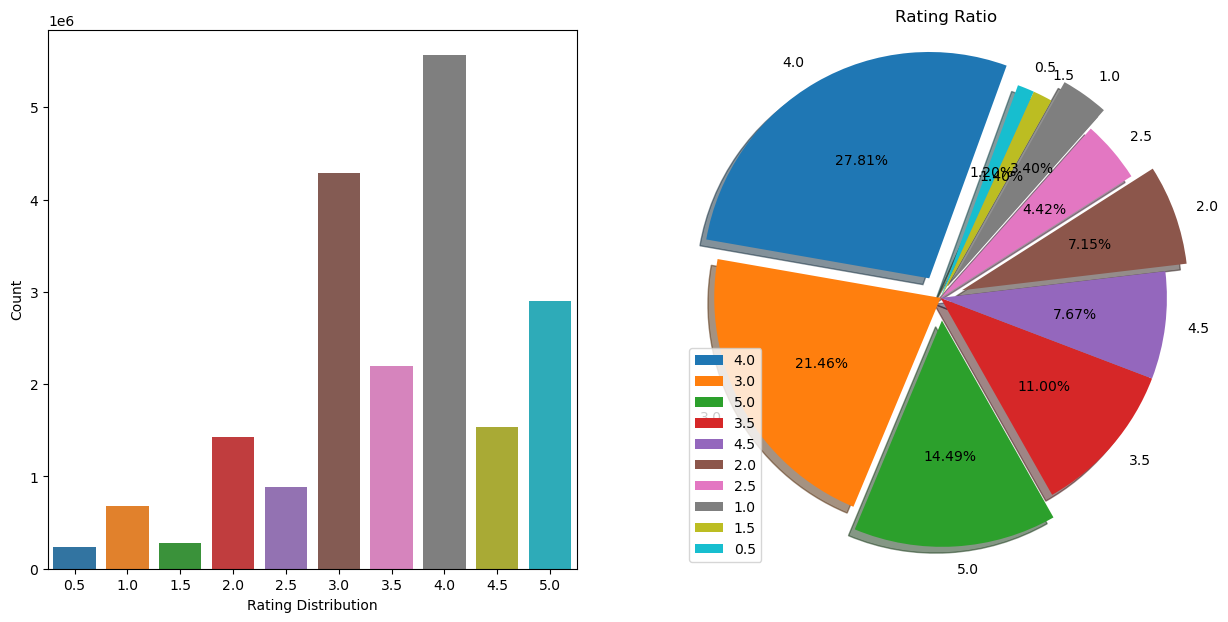

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
sns.countplot(review['rating'], ax=ax1)
ax1.set_xlabel('Rating Distribution', fontsize=10)
ax1.set_ylabel('Count', fontsize=10)

explode = (0.1, 0, 0.1, 0, 0, 0.1, 0, 0.1, 0, 0)
ax2.pie(rating_counts['Rating'], explode=explode, labels=rating_counts.Labels, autopct='%1.2f%%',
       shadow=True, startangle=70)
ax2.axis('equal')
plt.title("Rating Ratio")
plt.legend(rating_counts.Labels, loc=3)
plt.show()


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model

In [11]:
# We start by creating a binary target variable as pertaining to rating

actual_mean = review['rating'].mean()
review['rating'] = review['rating'] + (3.0 - actual_mean)

review['recommend'] = review['rating'] > 3.0
review.tail()

,userId,movieId,rating,timestamp,recommend
20000258,138493,68954,3.974471,2009-11-13 15:42:00,True
20000259,138493,69526,3.974471,2009-12-03 18:31:48,True
20000260,138493,69644,2.474471,2009-12-07 18:10:57,False
20000261,138493,70286,4.474471,2009-11-13 15:42:24,True
20000262,138493,71619,1.974471,2009-10-17 20:25:36,False


In [12]:
review['recommend'].value_counts()

False    10004853
True      9995410
Name: recommend, dtype: int64

Text(0.5, 1.0, 'Recommendation Distribution')

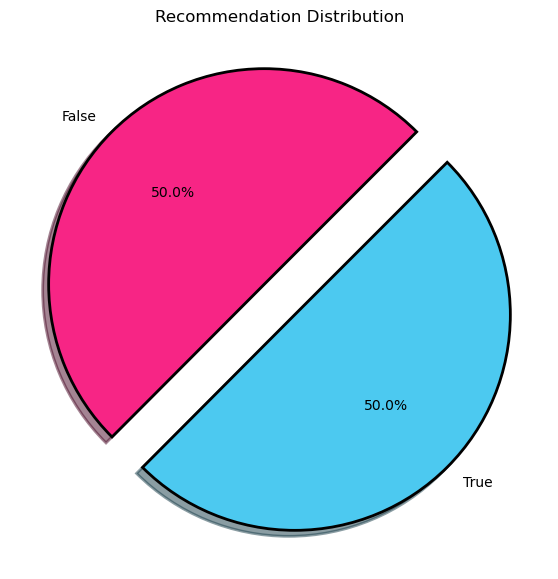

In [13]:
fig = plt.figure(figsize=(7,7))
colors = ('#f72585', '#4cc9f0')
wp = {'linewidth':2, 'edgecolor': 'black'}
tags = review['recommend'].value_counts()
explode = (0.1, 0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow = True, colors = colors,
         startangle=45, wedgeprops= wp, explode = explode, label='')
plt.title('Recommendation Distribution')
                  

In [14]:
# Let's handle the data imbalance using oversampling (SMOTE)
X = review[['userId', 'movieId']]
y = review['recommend']
smote = SMOTE(random_state=42)
X_sampled, y_sampled = smote.fit_resample(X, y)

In [15]:
# Let's make a Feature Scaling
scaler = StandardScaler()
X_sampled[['userId', 'movieId']] = scaler.fit_transform(X_sampled[['userId', 'movieId']])

In [16]:
# we proceed by train-testing splitting 
X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.33)

### Model Classification and Evaluation

In [17]:
# Tensorflow model
input_layer = layers.Input(shape=(2,))
dense_1 = layers.Dense(128, activation='relu')(input_layer)
dense_2 = layers.Dense(64, activation='relu')(dense_1)
output_layer = layers.Dense(1, activation='sigmoid')(dense_2)
tf_model = Model(inputs=input_layer, outputs=output_layer)

tf_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
tf_model.fit(X_train, y_train, epochs=3, batch_size=128, validation_split=0.2)
tf_preds = tf_model.predict(X_test)
tf_accuracy = accuracy_score(y_test, tf_preds.round())

Epoch 1/3
83791/83791 [==============================] - 261s 3ms/step - loss: 0.6881 - accuracy: 0.5327 - val_loss: 0.6869 - val_accuracy: 0.5384
Epoch 2/3
83791/83791 [==============================] - 245s 3ms/step - loss: 0.6862 - accuracy: 0.5375 - val_loss: 0.6853 - val_accuracy: 0.5396
Epoch 3/3
83791/83791 [==============================] - 249s 3ms/step - loss: 0.6860 - accuracy: 0.5382 - val_loss: 0.6852 - val_accuracy: 0.5379


In [18]:
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_preds)

In [19]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
knn_preds = knn_model.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_preds)

### Classification Report for a more comprensive evaluation


In [20]:
lr_report = classification_report(y_test, lr_preds)
tf_report = classification_report(y_test, tf_preds.round())
knn_report = classification_report(y_test, knn_preds)

In [21]:
print(f'Linear Regression Accuracy: {lr_accuracy}')
print(f'TensorFlow Accuracy: {tf_accuracy}')
print(f'KNN Accuracy: {knn_accuracy}')

Linear Regression Accuracy: 0.5052938702626589
TensorFlow Accuracy: 0.5375694189622824
KNN Accuracy: 0.5749172030603936


In [22]:
print('Linear Regression Classification Report')
print(lr_report)
print('TensorFlow Classification Report')
print(tf_report)
print('KNN Classification Report')
print(tf_report)

Linear Regression Classification Report
              precision    recall  f1-score   support

       False       0.52      0.14      0.23   3300897
        True       0.50      0.87      0.64   3302306

    accuracy                           0.51   6603203
   macro avg       0.51      0.51      0.43   6603203
weighted avg       0.51      0.51      0.43   6603203

TensorFlow Classification Report
              precision    recall  f1-score   support

       False       0.52      0.84      0.64   3300897
        True       0.60      0.24      0.34   3302306

    accuracy                           0.54   6603203
   macro avg       0.56      0.54      0.49   6603203
weighted avg       0.56      0.54      0.49   6603203

KNN Classification Report
              precision    recall  f1-score   support

       False       0.52      0.84      0.64   3300897
        True       0.60      0.24      0.34   3302306

    accuracy                           0.54   6603203
   macro avg       0.56      